# ⌚️ DM&ML 2020 - Team Rolex

## 🖋 Authors
- Francis Ruckstuhl, 16-821-738
- Hanna Birbaum, 16-050-114
- Loïc Rouiller-Monay, 16-832-453

## 🕵️ Project description

Real or Not? NLP with Disaster Tweets: Machine Learning model that can predict which tweets are about a real disaster and which are not. The project topic is based around a Kaggle competition.


## 📝 Commits

### Best commit:

**Commit 2 : 0.818%**
- data cleaning : remove unicode literals, urls, link, author, hashtags, rt
- feature engineering : num_chars, num_words, avg_words
- BOW
- LogisticRegression(solver='lbfgs', max_iter=1000)

### [B.] Previous commits

**Commit 1 : 0.808%**
- spacy_tokenizer: remove stopwords, punctuation, numbers then lemmatize and lowercase
- TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)
- LogisticRegression(solver='lbfgs', max_iter=1000)

**Commit 2 : 0.818%**
- data cleaning : remove unicode literals, urls, link, author, hashtags, rt
- feature engineering : num_chars, num_words, avg_words
- BOW
- LogisticRegression(solver='lbfgs', max_iter=1000)

**Commit 3 : 0.809%**
- data cleaning : remove unicode literals, urls, link, author, hashtags, rt, punctuations, lowercase
- feature engineering : num_chars, num_words, avg_words, num_hashtags
- BOW
- LogisticRegression(solver='lbfgs', max_iter=1000)

### [C.] Progression of accuracies

<AxesSubplot:xlabel='commit_number', ylabel='accuracy'>

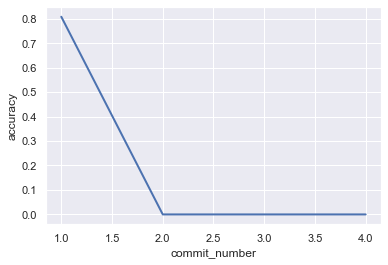

In [2]:
# /!\ You have to run Chapter 1. "libraries“ first before being able to plot the progression of accuracies
accuracy_progression = pd.read_csv('../documents/accuracy_progression.csv', sep=';')
sns.lineplot(x=accuracy_progression.commit_number, y=accuracy_progression.accuracy, linewidth=2)

# 📚 1. Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
import spacy
# load English language model of spacy
sp = spacy.load('en_core_web_sm')
import string
import pycountry
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

from gensim.models.doc2vec import TaggedDocument

# 📂 2. Download data


## Files
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

In [2]:
train = pd.read_csv('../data/training_data.csv')
test = pd.read_csv('../data/test_data.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

In [3]:
train.head(5)

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


## Features
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        6471 non-null   int64 
 1   keyword   6416 non-null   object
 2   location  4330 non-null   object
 3   text      6471 non-null   object
 4   target    6471 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 252.9+ KB


# 🔬 3. Exploratory Data Analysis

## [A.] What is the baserate of the problem?

In [5]:
base_rate = train.target.value_counts().max()/len(train)
print(f'\nThe base rate is {base_rate}')


The base rate is 0.5719363313243703


## Target class distribution

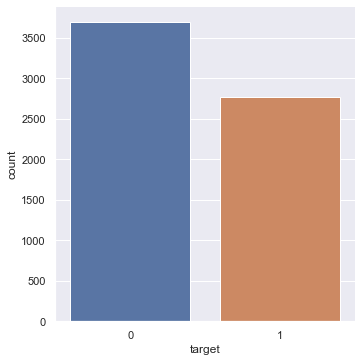

In [6]:
sns.catplot(x="target", kind="count", data=train);

## Missing values

In [7]:
train.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

It misses value in two features : keyword and location.

### Missing value in "keyword"

In [8]:
train.keyword.isnull().value_counts()

False    6416
True       55
Name: keyword, dtype: int64

### Missing value in "location"

In [9]:
train.location.isnull().value_counts()

False    4330
True     2141
Name: location, dtype: int64

## Tweets length

### Number of characters

In [10]:
train["num_char"] = train["text"].apply(len)
test["num_char"] = test["text"].apply(len)

<AxesSubplot:xlabel='target', ylabel='num_char'>

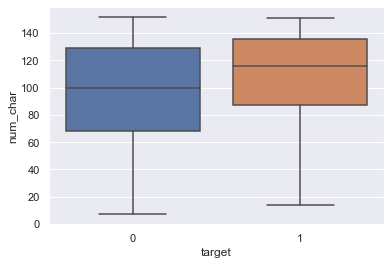

In [11]:
sns.boxplot(x='target', y='num_char', data=train)

##### Findings
Tweets about real disaster seems to be lengthier.

### Number of words

In [12]:
train["num_words"] = train["text"].apply(lambda x: len(x.split()))
test["num_words"] = test["text"].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='target', ylabel='num_words'>

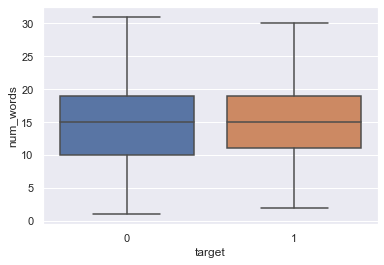

In [13]:
sns.boxplot(x='target', y='num_words', data=train)

##### Findings
Tweets about real disaster do not seem to have more words. Maybe it'll help to take this into consideration.

### Average word length

In [14]:
train["avg_word_length"] = train['text'].apply(lambda x: np.sum([len(w) for w in x.split()]) / len(x.split()))
test["avg_word_length"] = test['text'].apply(lambda x: np.sum([len(w) for w in x.split()]) / len(x.split()))

<AxesSubplot:xlabel='target', ylabel='avg_word_length'>

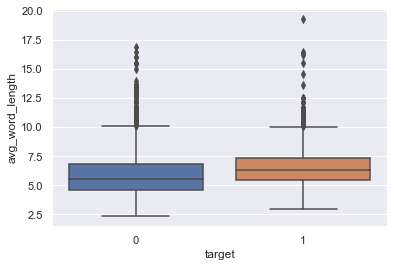

In [15]:
sns.boxplot(x='target', y='avg_word_length', data=train)

##### Findings
Tweets about real disaster seems to have lengtier average word length

### Number of hashtags in text

In [29]:
train['num_hashtags'] = train['text'].apply(lambda x: x.count('#'))
test['num_hashtags'] = test['text'].apply(lambda x: x.count('#'))

<AxesSubplot:xlabel='target', ylabel='num_hashtags'>

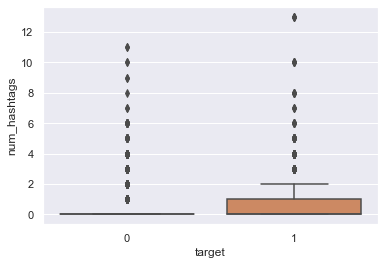

In [17]:
sns.boxplot(x='target', y='num_hashtags', data=train)

### Locate disasters

In [18]:
# Where do most disasters occur / where do disaster tweets come from? 
# Potential problem to take care of: USA and United States are separate; Different US States are also separate;
# train.loc[train["target"] == 1, ["location"]].value_counts()

# 🧹 4. Data cleaning

## Keywords

In [100]:
# remove '%20' from keyword feature
train.keyword = train.keyword.apply(lambda x: str(x).replace('%20', ' '))
test.keyword = train.keyword.apply(lambda x: str(x).replace('%20', ' '))

In [101]:
# check if NaN values in the keyword feature
print(train.keyword.isnull().any())
print(test.keyword.isnull().any())

False
False


In [102]:
# use pycountry in order to check if a country appears in the location
# if yes takes the country, else turn it to NaN
# with train and test data set

In [103]:
# train.location.apply(lambda x: print(x))

## Text

In [137]:
test = 'It is a test... test!'

In [141]:
''.join([ char for char in test if char not in punctuations ])

'It is a test test'

In [66]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation

def clean_text(text):
    # remove unicode literals
    temp = text.encode('ascii',errors='ignore').decode('ascii')
    
    # remove &amp
    temp = temp.replace('&amp;', '')
    
    # remove urls
    temp = re.sub(r"http\S+", "", temp)
    
    # remove html
    temp = re.sub(r'<.*?>', "", temp)
    
    # remove hashtags
    temp = re.sub(r'#', "", temp)

    # remove people account with @
    temp = re.sub(r'@\S+', "", temp)
    
    # remove 'RT'
    # temp = temp.replace('RT', '')
    
    # remove punctuation
    # temp = ''.join([ char for char in temp if char not in punctuations ])
    
    # remove stop words
    temp = ''.join([ char for char in temp if char not in stop_words ])
    
    # lowercase
    temp = temp.lower()
    
    return temp

In [50]:
# TO DO
# count number of hashtags
# count the number of retweets
# maybe remove RT

In [67]:
# clean text
train.text = train.text.apply(lambda x: clean_text(x))
test.text = test.text.apply(lambda x: clean_text(x))

In [47]:
# todo: régler les problèmes d'encodage: Ûª, Û_, Ûª, &amp, ;#number_of_any_length;
# création d'une expression regulière; could be helpful to remove these:
# regex = re.compile(r"(Ûª|Û_|Ûª|&amp|(\d+)|((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*))")

# enlever les liens, juste les hashtags, lowercase, ponctuation
# en option voir si enlever les "@ + les pseudos" ça aide

In [68]:
train.text.apply(lambda x: print(x))

blck eye 9  spce bttle occurred t str o784 nvolvng 3 fleets totlng 3945 shps wth 17 destroyed
world fedex no longer to trnsport boterror germs n wke of nthrx lb mshps  
relty trnng trn flls off elevted trcks durng wndstorm  prmedc ems
twn grce expect tht lrge rocks trees mud unstble ndor sturted lnd my slde very hzrdous n hllymountn res
new ss vdeo ss thretens to behed crotn hostge wthn 48 hours  tlvfces  tlvfcesuspol 
freebeseged mrtnmj22 yougov whch tory lndslde  you cnt possbly men the wferthn mjorty of g 
bllonres hve  pln to free hlf  bllon dollrs trpped n venezuel for two yers  reports


 some old testmony of wepons used to promote conflcts
tctcs  corrupton  nfltrton of groups

l you flew plnes nd rn nto burnng buldngs why re you mkng soup for tht mn chld boordleyvncullen
the thunder shook my house woke my sster nd mde cr lrms go off 
polce montorng 200 jhds n polnd  v 
my dd s pnckng s my weght loss mens he needs to hurry up wth my new clothes fundwhen  rech my gol  
lleged drve

 the reson  brng ths up  bcz he s runnng 4 sente murphy s nothng but  republcn  m deluged wth hs junk ml
redy for my close up errrr nope notgongoutntht hlstorm lbert    
501 sky news mndem n tottehm gong mddddd burnng up fed crs n dem tng dere
stll mortfed tht when  went to roses  collpsed on my heels fce plnted n front of everyone nd broke my fv shoes
yumko jumped n surprse s the fre shot upwrds nto the r nd exploded cught off gurd woh she hd  
slmc stte group n egypt thretens to kll crot hostge 
wter now tops the chrts for hghest globl rsk n terms of devstton hed of nucler wr or  globl pndemc 
nowplyng rsonst mc   so mpressed    
 drowned n the kdde pool nd  lost my ploppy
 slcker thn n ol spll
one drecton s my pck for  fn rmy drectoners  x1411
holy fuck qvc btch just got burned so hrd
oky  need ll of you to evcute the house so  cn wrte ths poem
the ltest more homes rzed by northern clforn wldfre  bc news 
jpn on thursdy mrks the 70th nnversry of the tomc bombng of hroshm wth the mos

jmes kunstler how bd rchtecture wrecked ctes  resdulncome mlm 
books  flght to burm when country s endurng poltcl unrest nd  nturl dsster no wonder t ws so chep y
bbc news  nd rl crsh trns derl n mdhy prdesh flsh flood 
 rted ctstrophe 2015 810  mdb  hlrous 
f you hve trouble gettng motvted remember tht tme s gong to pss nd tht regret s gong to mke ts wy round  mtthew donnelly
  ts mpossble for me too ww lke  cnt survve  dy wthout met wew
crmer gers 3 words tht wrecked dsneys stock  cnbc 
 lke gg ws bd n the end but t lest  cred  lttle when gg ws dn cuse t ws  twster  dont know wlden dc
jpn mrks 70th nnversry of hroshm tomc bombng bells tolled n hroshm on thursdy s jpn mrked 70 
 you ok need  mbulnce hhhh tht ws good 
tuns bech msscre lnked to mrch terror ttck on museum 
ths s  one drecton conce not  wr zone wht s ths otrmetlfe 
rnhem wether  ltpgtn unrelentng nd dngerous het wve wll expnd cross the south centrl unted sttes 
 lwys felt lke the nmekns were blck people nd felt plyed when

best move youve ever seen  rmgeddon  
 desert storm ws n unqulfed vctory  trety ws sgned  under clnton the stuton only got worse nd more volent tcot
c130 speclly modfed to lnd n  stdum nd rescue hostges n rn n 1980  
 hh so would you sy ts so hot your blls re burnng off
computers gdgets two gnt crnes holdng  brdge collpse nto nerby homes  slngnews
trcycle toddler tomc bomb
 n  frcton of  second our decsons chnge the lndscpe of humnty
vehcle hjckng n  vosloorus guteng on 20150805 t 2300 whte toyot conquest  bkb066gp 
 thnks for the dmn hert ttck
gelte 0    exploson greg 2 top 3rd 0 out 0 blls 0 strkes  no one on p 16 morgn orchrd b 
my brothernlw rooooos got the cll to hed up north nd fght the wld fres dudes  best t 
  wld b  shme f tht golf crt becme engulfed n flmes boycottbers
ud rescue structurl collpse  scott rod  ypres rod york 14 trucks
brtons rescued md hmly floods   
creelyou must thnk m  rel moron flg mn  brnless mss of muscle  dobut  dont thnk youre  mss murderer
tred ornge f

0       None
1       None
2       None
3       None
4       None
        ... 
6466    None
6467    None
6468    None
6469    None
6470    None
Name: text, Length: 6471, dtype: object

## Location

In [11]:
train.location.isnull().value_counts()

False    4330
True     2141
Name: location, dtype: int64

# 🛠 [D.] 5. Feature Engineering

In [26]:
pycountry.countries.search_fuzzy('England')

[Country(alpha_2='GB', alpha_3='GBR', name='United Kingdom', numeric='826', official_name='United Kingdom of Great Britain and Northern Ireland')]

In [27]:
# not good 

def location_to_country(location):
    temp = location.split(',')
    countries = list(pycountry.countries)
    
    for word in temp:
        for i in range(len(countries)):
            if (word.strip() in countries[i].alpha_2) or (word.strip() in countries[i].alpha_3) or (word.strip() in countries[i].name):
                return countries[i].name
    return 'Unknown'

train['country'] = train.location.apply(lambda x: location_to_country(str(x)))
train[['location', 'country']].head(60)

,location,country
0,USA,United States
1,NaN,Unknown
2,"Palm Beach County, FL",Falkland Islands (Malvinas)
3,USA,United States
4,Australia,Australia
5,Scotland,Unknown
6,New York City,Unknown
7,Multinational *****,Unknown
8,Los Angeles,Unknown
9,NaN,Unknown


# ⚙️ 6. Preprocessing

In [28]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    punctuations = string.punctuation
    # numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    
    # Remove all word with less that 3 letters (remove noise)
    mytokens = [ word for word in mytokens if len(word)>2 ]

    # Return preprocessed list of tokens
    return mytokens

In [29]:
# Tokenize texts
processed_texts = []
for text in train.text:
    processed_text = spacy_tokenizer(text)
    processed_texts.append(processed_text)

# 🤖 7. Models

## BOW with Logistic Regression

In [53]:
# Using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words="english")
bow = count.fit_transform(train.text)

In [54]:
# Get feature names
feature_names = count.get_feature_names()

In [55]:
# Show as a dataframe
processed_train = pd.DataFrame(
    bow.todense(), 
    columns=feature_names
    )

In [56]:
# Select features
X = processed_train # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [57]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=1000, cv=5)

In [58]:
# Fit model on training set
classifier.fit(X_train, y_train)

LogisticRegressionCV(cv=5, max_iter=1000)

In [59]:
# Predictions
y_pred = classifier.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7923


#### BOW with more additional features

In [69]:
train_full = pd.concat([processed_train, train[['num_char', 'avg_word_length']]], axis=1)

In [71]:
# Select features
X = train_full # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [72]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=3000, cv=4)

In [ ]:
%%time
# Fit model on training set
classifier.fit(X_train, y_train)

In [ ]:
# Predictions
y_pred = classifier.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

#### BOW with additional features and Decision tree

In [ ]:
train_full = pd.concat([train[['num_char', 'num_words', 'avg_word_length']], processed_train], axis=1)

In [ ]:
# Select features
X = processed_train # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [149]:
# Define classifier
classifier = DecisionTreeClassifier()

In [150]:
# Fit model on training set
classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [151]:
# Predictions
y_pred = classifier.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7459


## TF-IDF with Logistic Regression

In [69]:
# Select features
X = train['text'] # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [82]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=spacy_tokenizer)

# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=1000, cv=5)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

/Users/loic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/loic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

CPU times: user 1min 22s, sys: 1.82 s, total: 1min 24s
Wall time: 1min 37s


/Users/loic/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=5, sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x7fa8afbc5430>)),
                ('classifier', LogisticRegressionCV(cv=5, max_iter=1000))])

In [83]:
# Predictions
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7776


## Decision tree

In [73]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Define classifier
classifier = DecisionTreeClassifier()

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

CPU times: user 1min 14s, sys: 1.74 s, total: 1min 16s
Wall time: 1min 41s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x7fa8afbc5430>)),
                ('classifier', DecisionTreeClassifier())])

In [74]:
# Predictions
y_pred = pipe.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7205


## Classification using Doc2Vec and Logistic Regression

In [37]:
sample_tagged = train.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['text']), tags=[r.target]), axis=1)

NameError: name 'spacy_tokenizer' is not defined

In [38]:
# Train test split - same split as before
train_tagged, test_tagged = train_test_split(sample_tagged, test_size=0.2, random_state=1234)

NameError: name 'sample_tagged' is not defined

In [ ]:
# Allows to speed up a bit
import multiprocessing
cores = multiprocessing.cpu_count()

In [ ]:
# Define Doc2Vec and build vocabulary
from gensim.models import Doc2Vec

model_dbow = Doc2Vec(dm=1, vector_size=100, negative=5, hs=0, min_count=1, sample=0, workers=cores, epoch=500)
model_dbow.build_vocab([x for x in train_tagged.values])

In [ ]:
# Train distributed Bag of Word model
model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

In [50]:
# Select X and y
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=300)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

# Each document (i.e. complaint) is now a vector in the space of 30 dimentions.
# Similar complaints should have similar vector representation.

In [51]:
# Fit model on training set - same algorithm as before
logreg = LogisticRegressionCV(max_iter=3000, cv=3, solver='lbfgs')
logreg.fit(X_train, y_train)

LogisticRegressionCV(cv=3, max_iter=3000)

In [52]:
# Predictions
y_pred = logreg.predict(X_test)

# Evaluate model
print(round(accuracy_score(y_test, y_pred), 4))

0.7876


## Classification using Doc2Vec, more features and Logistic Regression

# 🏆 8. Submission

## BOW

In [19]:
# Using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words="english")
bow = count.fit(train.text)
bow = count.transform(train.text)

In [20]:
# Get feature names
feature_names = count.get_feature_names()

In [21]:
# Show as a dataframe
processed_train = pd.DataFrame(
    bow.todense(), 
    columns=feature_names
    )

In [22]:
train_full = pd.concat([train[['num_char', 'num_words', 'avg_word_length', 'num_hashtags']], processed_train], axis=1)

In [23]:
# Select features
X = train_full # the features we want to analyze
y = train['target'] # the labels, or answers, we want to test against

In [24]:
# Define classifier
classifier = LogisticRegressionCV(solver='lbfgs', max_iter=6000, cv=3)

In [25]:
%%time
# Fit model on training set
classifier.fit(X, y)

Wall time: 1h 38min 30s


LogisticRegressionCV(cv=3, max_iter=6000)

In [30]:
bow_test = count.transform(test.text)
# Get feature names
feature_names_test = count.get_feature_names()

In [31]:
# Show as a dataframe
processed_test = pd.DataFrame(
    bow_test.todense(),
    columns=feature_names_test
    )

In [32]:
test_full = pd.concat([test[['num_char', 'num_words', 'avg_word_length' , 'num_hashtags']], processed_test], axis=1)

In [33]:
# Predictions

y_pred = classifier.predict(test_full)

## TF IDF

In [28]:
# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

In [29]:
pipe.fit(train.text, train.target)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(encoding='latin-1', min_df=5,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x000001A08775D040>)),
                ('classifier', LogisticRegression(max_iter=1000))])

In [30]:
preds = pipe.predict(test.text)

In [31]:
preds

array([0, 0, 1, ..., 1, 0, 1], dtype=int64)

## Export submission

In [34]:
sample_submission.target = y_pred

In [35]:
sample_submission

,target
0,0
1,0
2,1
3,0
4,0
...,...
1137,1
1138,1
1139,1
1140,0


In [36]:
sample_submission.to_csv('submission-003.csv', index=False)